File or folder: C:\Users\nazih\satellite-aukf-assignment\orekit-data.zip  not found


            The Orekit library relies on some external data for physical models.
            Typical data are the Earth Orientation Parameters and the leap seconds history,
            both being provided by the IERS or the planetary ephemerides provided by JPL.
            Such data is stored in text or binary files with specific formats that Orekit knows
            how to read, and needs to be provided for the library to work.

            You can download a starting file with this data from the orekit gitlab at:
            https://gitlab.orekit.org/orekit/orekit-data

            or by the function:
            orekit.pyhelpers.download_orekit_data_curdir()

            
✔️  Orekit data registered: C:\Users\nazih\satellite-aukf-assignment\orekit-data


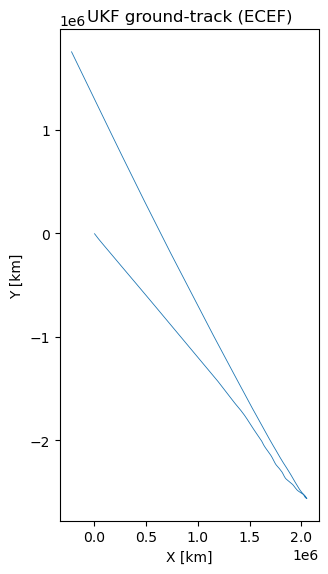

In [1]:
# 03_ukf_demo.ipynb

import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 1) load & prep
df        = pd.read_parquet("GPS_clean.parquet")
meas_cols = json.load(open("meas_cols.json"))
meas      = df[meas_cols].values.astype("float64")
epochs    = df["time"].values.astype("datetime64[s]")

# 2) propagator & UKF
from utils  import OrbitPropagator, plot_ground_track
from aukf   import UnscentedKalman

prop = OrbitPropagator()
ukf  = UnscentedKalman(
    prop,
    meas_cols,
    q0=1e-2,
    r0=25.0,
    adaptive="iae"    # Innovation‐based adaptive R
)

# 3) initialize
ukf.init_from_measurement(0.0, meas[0])
prev_t = epochs[0]

# 4) step through all epochs
for t, z in zip(epochs[1:], meas[1:]):
    dt = (t - prev_t).astype(int)
    ukf.step(float(dt), z)
    prev_t = t

# 5) extract & plot
hist = np.vstack([x for _, x in ukf.history])
plot_ground_track(hist, title="UKF ground-track (ECEF)")
